In [1]:
# os.path.abspath("Weatherforecasting.ipynb")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from datetime import datetime
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

In [3]:
data = pd.read_csv("seattle-weather.csv")
weather = data.copy()

In [4]:
data.tail()

,date,precipitation,temp_max,temp_min,wind,weather
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun
1460,2015-12-31,0.0,5.6,-2.1,3.5,sun


In [5]:
data[data["date"] == "2015-07-06"]

,date,precipitation,temp_max,temp_min,wind,weather
1282,2015-07-06,0.0,29.4,15.6,3.2,drizzle


In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [7]:
weather.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


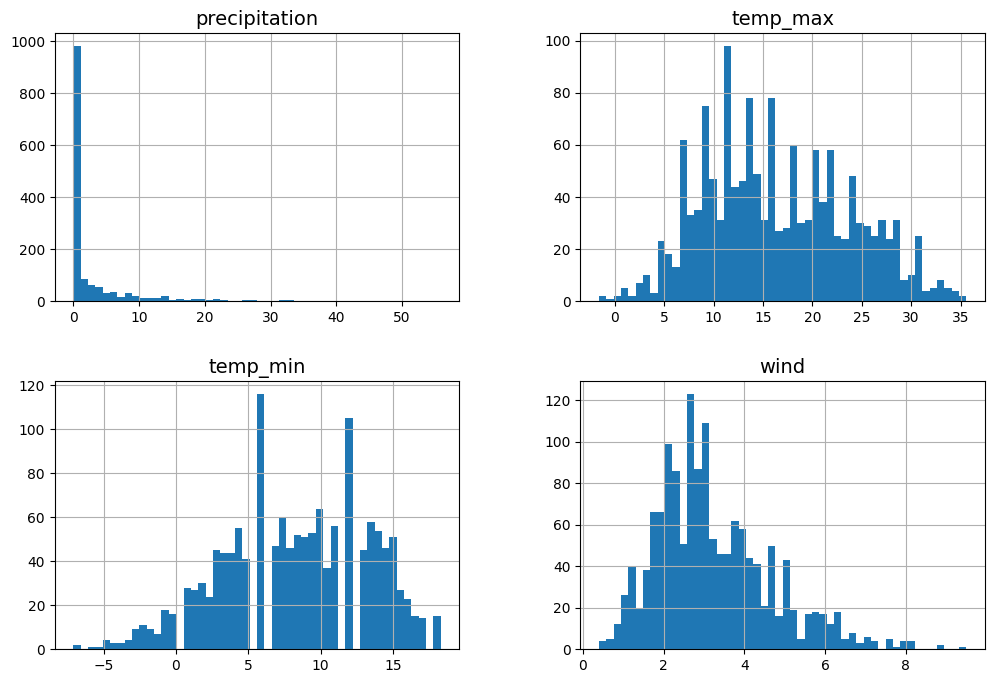

In [8]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

weather.hist(bins=50, figsize=(12, 8))
plt.show()

In [9]:
scaler_wind = StandardScaler()
weather['wind'] = scaler_wind.fit_transform(weather[['wind']])

scaler_temp_min = StandardScaler()
weather['temp_min'] = scaler_temp_min.fit_transform(weather[['temp_min']])

scaler_temp_max = StandardScaler()
weather['temp_max'] = scaler_temp_max.fit_transform(weather[['temp_max']])

scaler_precipitation = MinMaxScaler()
weather['precipitation'] = scaler_precipitation.fit_transform(weather[['precipitation']])

minmax_scaler = MinMaxScaler()
weather['precipitation'] = minmax_scaler.fit_transform(weather[['precipitation']])

joblib.dump(scaler_wind, "models/scaler_wind.pkl")
joblib.dump(scaler_temp_min, "models/scaler_temp_min.pkl")
joblib.dump(scaler_temp_max, "models/scaler_temp_max.pkl")
joblib.dump(scaler_precipitation, "models/scaler_precipitation.pkl")
joblib.dump(minmax_scaler, "models/minmax_scaler.pkl")

['models/minmax_scaler.pkl']

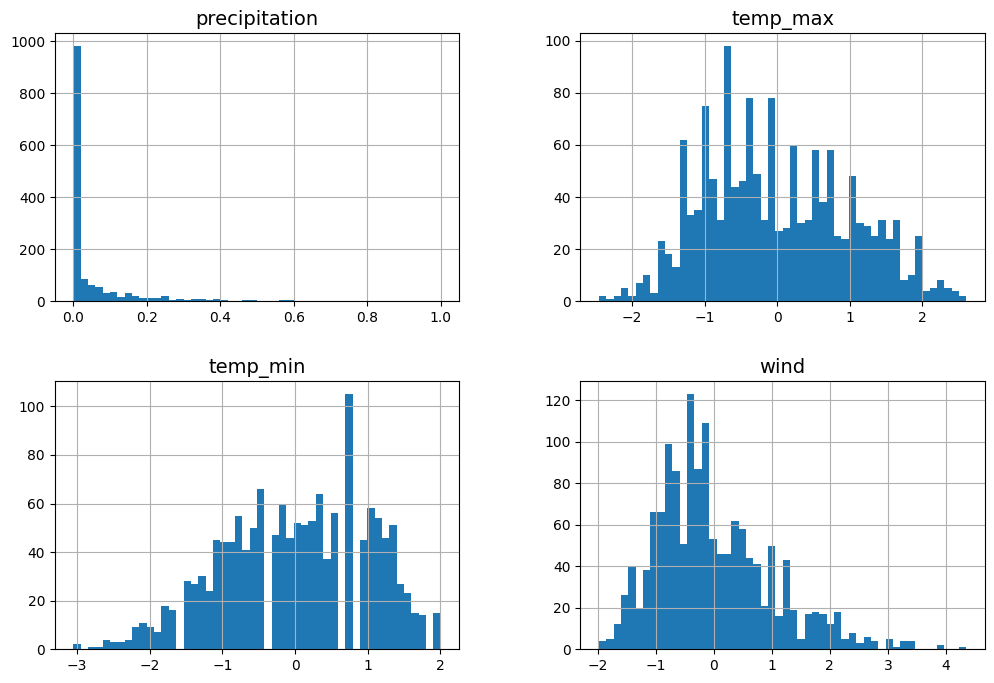

In [10]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

weather.hist(bins=50, figsize=(12, 8))
plt.show()

In [11]:
weather["weather"].value_counts()

weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64

In [12]:
le = LabelEncoder()
weather['weather'] = le.fit_transform(weather['weather'])

In [13]:
weather['date'] = pd.to_datetime(weather['date'])
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather['day'] = weather['date'].dt.day

weather = weather.drop('date', axis=1)

In [14]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  1461 non-null   float64
 1   temp_max       1461 non-null   float64
 2   temp_min       1461 non-null   float64
 3   wind           1461 non-null   float64
 4   weather        1461 non-null   int64  
 5   year           1461 non-null   int32  
 6   month          1461 non-null   int32  
 7   day            1461 non-null   int32  
dtypes: float64(4), int32(3), int64(1)
memory usage: 74.3 KB


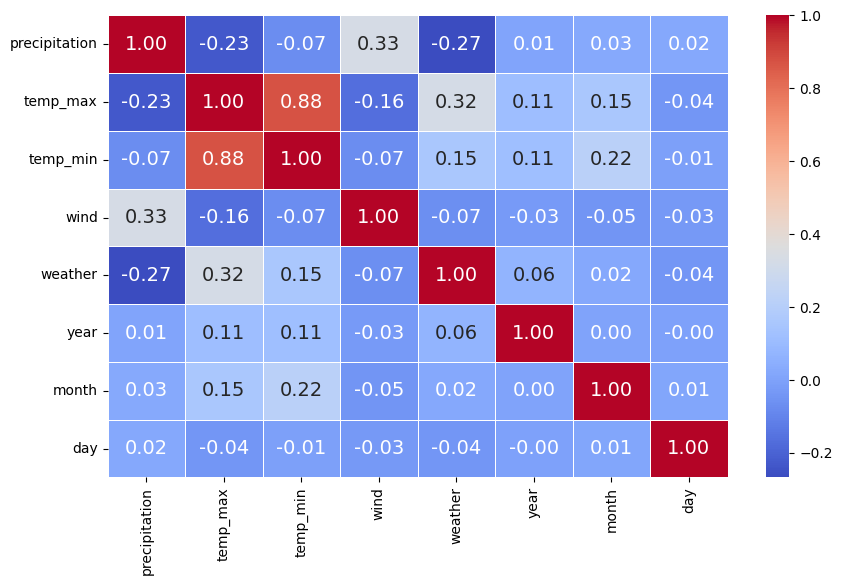

In [15]:
corr_matrix = weather.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.show()

In [16]:
X = weather.drop('temp_max', axis=1)
X.to_csv("models/X_last.csv", index=False)
y = weather['temp_max']

In [17]:
horizon = 7
lookback = 14

# Функция создания ряда
def create_sequences(X, y, lookback=lookback, horizon=horizon):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback - horizon + 1):
        X_seq.append(X.iloc[i:i + lookback].values.flatten())
        y_seq.append(y.iloc[i + lookback:i + lookback + horizon].values)
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y)

# Делим данные для временных рядов
split_idx = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

In [18]:
models = []
metrics = []

for i in range(horizon):
    model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_seq, y_train_seq[:, i])
    y_pred = model.predict(X_test_seq)
    
    mae = mean_absolute_error(y_test_seq[:, i], y_pred)
    rmse = mean_squared_error(y_test_seq[:, i], y_pred)
    r2 = r2_score(y_test_seq[:, i], y_pred)
    
    print(f"Day {i+1} — MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")
    
    models.append(model)
    metrics.append({'mae': mae, 'rmse': rmse, 'r2': r2})

Day 1 — MAE: 0.373, RMSE: 0.230, R2: 0.759
Day 2 — MAE: 0.439, RMSE: 0.309, R2: 0.682
Day 3 — MAE: 0.452, RMSE: 0.311, R2: 0.684
Day 4 — MAE: 0.429, RMSE: 0.299, R2: 0.700
Day 5 — MAE: 0.462, RMSE: 0.321, R2: 0.679
Day 6 — MAE: 0.453, RMSE: 0.320, R2: 0.683
Day 7 — MAE: 0.448, RMSE: 0.316, R2: 0.690


In [19]:
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

joblib.dump(X_scaler, "models/X_scaler.pkl")
joblib.dump(y_scaler, "models/y_scaler.pkl")

def create_lstm_sequences(X, y, lookback, horizon):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback - horizon + 1):
        X_seq.append(X[i:i + lookback])
        y_seq.append(y[i + lookback:i + lookback + horizon].flatten())
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_lstm_sequences(X_scaled, y_scaled, lookback, horizon)

split_idx = int(len(X_seq) * 0.8)
X_train_lstm, X_test_lstm = X_seq[:split_idx], X_seq[split_idx:]
y_train_lstm, y_test_lstm = y_seq[:split_idx], y_seq[split_idx:]

In [20]:
model = Sequential([
    Input(shape=(lookback, X_seq.shape[2])),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)),
    LayerNormalization(),
    Dropout(0.3),
    LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001)),
    LayerNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(horizon)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_lstm,
    y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.4831 - mae: 0.4640 - val_loss: 0.1831 - val_mae: 0.2104
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1986 - mae: 0.2318 - val_loss: 0.1700 - val_mae: 0.2157
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1640 - mae: 0.1888 - val_loss: 0.1594 - val_mae: 0.2121
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1478 - mae: 0.1698 - val_loss: 0.1127 - val_mae: 0.1032
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1297 - mae: 0.1484 - val_loss: 0.1084 - val_mae: 0.1100
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1174 - mae: 0.1338 - val_loss: 0.1000 - val_mae: 0.1024
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1080 - mae: 0.1247 - val_loss: 0.0954 - val_mae: 0.1050
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1001 - mae: 0.1213 - val_loss: 0.0897 - val_mae: 0.1049
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.092

In [21]:
y_pred_lstm = model.predict(X_test_lstm)
y_pred_denorm = scaler_temp_max.inverse_transform(y_pred_lstm)
y_test_denorm = scaler_temp_max.inverse_transform(y_test_lstm)

# Оценка
mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
r2 = r2_score(y_test_denorm, y_pred_denorm)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
MAE: 0.59
RMSE: 0.73
R2: 0.74


In [22]:
model.save("models/model_lstm.keras")

In [23]:
model = load_model("models/model_lstm.keras")

In [24]:
user_input = {
    "precipitation": 0.0,
    "temp_min": 15.0,
    "wind": 3.5,
    "weather": 2,     
    "year": 2025,
    "month": 7,
    "day": 6
}

user_df = pd.DataFrame([user_input])

user_df['wind'] = scaler_wind.transform(user_df[['wind']])
user_df['temp_min'] = scaler_temp_min.transform(user_df[['temp_min']])
user_df['precipitation'] = scaler_precipitation.transform(user_df[['precipitation']])
user_df['weather'] = user_df['weather'].astype(int)
user_df['year'] = user_df['year'].astype(int)
user_df['month'] = user_df['month'].astype(int)
user_df['day'] = user_df['day'].astype(int)

last_context = X.iloc[-(lookback - 1):].copy()
full_context = pd.concat([last_context, user_df], ignore_index=True)

full_context_scaled = X_scaler.transform(full_context)

X_input = np.expand_dims(full_context_scaled, axis=0)

y_pred_scaled = model.predict(X_input)
y_pred = scaler_temp_max.inverse_transform(y_pred_scaled)

print("Предсказанные максимальные температуры на 7 дней вперёд:")
for i, temp in enumerate(y_pred[0]):
    print(f"Day {i + 1}: {temp:.2f} °C")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
Предсказанные максимальные температуры на 7 дней вперёд:
Day 1: 18.53 °C
Day 2: 18.30 °C
Day 3: 18.52 °C
Day 4: 18.34 °C
Day 5: 18.50 °C
Day 6: 18.52 °C
Day 7: 18.23 °C
